# Project 1 in Udacity Deep Reinforcement Learning Nanodegree - Navigation

### Introduction

This is the first project in the above mentioned nanodegree, in which we train an agent to navigate and collect bananas in a large, square world.

The game goes like this: A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana and the goal is to collect as many yellow bananas as possible without hitting blue bananas.

The state space has 37 dimensions, including the agent's velocity, together with ray-based perception of objects around agent's forward direction.  At each state, the agent has to learn how to best select one of the four discrete actions:

- **`0`** - move forward.
- **`1`** - move backward.
- **`2`** - turn left.
- **`3`** - turn right.

The task is episodic, and the target is to get an average score of +13 over 100 consecutive episodes.

### Setting up the system following the given instructions

To start with, you need to download and unzip the environment. You need to download the correct version for the platform you are using. The links for each of the system are given in the [project page](https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation). I installed on both Linux [from here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip) and 64 bits Windows [from here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86_64.zip). In both cases, there will be a directory with the executable and data, which I assume will be put in the same directory as the notebooks. In case of Windows, the name of the directory will be ```Banana_Windows_x86_64```
and for Linux ```Banana_Linux```. I have added two empty directories to have them visible.

To start the environment, you need to have the relative location of the Unity set correctly. If you follow the above instruction, on 64 bits machines with Windows it will be

```
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")
```

and with Linux

```
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
```

Initially, I met quite some difficulties before I could have the environment running on my system (Ubuntu 20.04). After that the environment started a black window appeared and then the execution was broken with error messages, which were somewhat difficult to understand. Finally, I figured out that my problem was related to incompatibility between Python version and unityagents. I created a conda environment with Python=3.6 and after activating the environment, I installed necessary packages. I.e.

```
conda create --name unity python=3.6
conda activate unity

pip install unityagents
pip install mlagents
pip install gym
pip install h5py
pip install Pillow
```

After that the notebook could run. Still a few points are worth mentioning. When the cell is executed, the Unity window opens and on a black background, it gives this message:

```
"Banana.x84_64" is not responding.
```

That is OK. Just let it be and continue execution of following cells. You should pass it by SHIFT ENTER or just running all the cells in the notebook. Also, I still had the following message in the terminal, where I started jupyter:

```
Unable to preload the following plugins:
 ScreenSelector.so
 libgrpc_csharp_ext.x86.so
```

and the following complain in Player.log

```
Fallback handler could not load library /home/abb001/git/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana_Data/Mono/libcoreclr.so
```

One last point worth of mentioning is a difference between Linux and Windows. On Windows I needed to cast the action to int when the environment was stepping forward, i.e.

```
env_info = env.step(int(action))[brain_name]
```

After these steps, I could move on to implement the algorithm.

### Implementation

In this section, the steps of implementation are described and the behaviour af the trained agent and the results are presented. Four different cases are implemented, of which the first three are step-by-step improvements according to the concepts presented in the lectures and the last one is an attempt to make the agent's behavior more intelligent. For each of these cases there are two notebooks, one for raining and testing and the case and one only for testing. More over, two script files are needed for the model and the agent. The trained network is saved in a file with ```.pth``` prefix.

Q-Learning refers to a class of algorithms for reinforcement learning, where the Q-function that predicts the maximum expected accumulated reward for each action at the current state is approximated in an iterative manner. In the original deep learning method, a deep network. called Deep Q-Network (DQN) was propoesd to estimate the Q-function. The iterative method can be described as following:

1. Set up a network, $Q(\theta)$, where $\theta$ denotes network parametres, which at each state predicts the accumulated discounted rewards for all possible actions. We can write it as $(Q(s, a; \theta)$ and initialize the parameters with a first random guess. Start at the initial state, $s=s^0$.
2. Use $Q(s, a; \theta)$ to to find the rewards for each actions and select the action with maxium reward $a^{max}$.
3. Take the greedy action $a^*$ and record the earned reward, $r$, and the new state, $s^{+1}$.
4. Calculate the expected maximum accumulated reward by $Q(s,a^{*}; \theta)$.
5. Calculate an estimate for the target value, by the sum of the actual earned reward and the estimated maximum discounted future reward using the network, i.e. $r+\gamma \text{ argmax}_a\left(Q(s^{+1},a;\theta)\right)$, where $\gamma$ is the discount factor. 
5. When the true Q-function is found, the difference between the two estimates should vanish. We search the solution by updating the weights so that the square root error in the batch becomes smaller.
6. If the target is not achieved, go to point 2, above and continue to iterate.

The above steps describe the basic algorithm. There are a number of improvements that have been proposed and found to be useful, such as:

1. Experience Replay and Double Deep Q-Network and fixed target network
   Using the same network for both selection of the greedy action and estimating the true values, the target, leads to some problems in the calucation. Using two different networks with the same structure will improve the behavior of the system.

   Experience Replay is simply recording the tuple $(s,a,r,s^{+1})$ in the memory and use randomly selected batches for learning.
2. Prioritized Experience Replay
   With prioritized experience replay, those tuples that have a larger contribution to the total error will be selected more often.
3. Dueling Douple Q-Network
   Dueling Q-network uses a special network struture to have a better estimate of the Q-function.

The above three improvements to Deep Q-Network are implemented and tested with the results presented below.

My initial trainings indicated that the agent could become very skilful fast. However, it made mistakes and got stuck in some cases, mistakes that a human player will not commit. My thought was that we do not do such mistakes as we not only see the bananas, but also remember the latest states togther with our own actions. To test this idea, I considered two cases, one, when only the states are taken as input to the networks and one where I added the selected action to the state vector as a for of $extended$ state and saved three stages of this extended state in a history buffer and used that as input to the networks. 

#### 1. Double Q-learning with Experience Replay
I started with the simplest case, DQN, taken from the previous code exercises from [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution) and adapted so that I could interact with the environment. 

In double Q-learning networks, two network with same structure are used for choice of action, step 2 in the above algorithm, and for calculation of the updated rewards, step 5 in the above description. In the implementation, the first network is called qnetwork_local and the second qnetwork_target. The optimization is done on parameters of the local network and the parameter values in the target network are relaxed to the updated local network parameters.

The network structure is presented below, with 4 layers. The input size is 37, the first hidden layer is roughly 3 times larger thant the size of input, 128 neurons, and then after two reductions by a factor of two, finally the networks ends with the output size of 4.

One state input:

```
QNetwork(
  (fc1): Linear(in_features=37, out_features=74, bias=True)
  (fc2): Linear(in_features=74, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)
```

Three state together with actions, i.e. input state will be $3\times(\text{Number of states}+\text{Number of actions})=123$ as input:

```
QNetwork(
  (fc1): Linear(in_features=123, out_features=246, bias=True)
  (fc2): Linear(in_features=246, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)
```

#### 2. Double Q-learning with Prioritized Experience Replay
In the second case, only prioritization is added to the selection of the batch from the replay memory. The probability of selecting a tuple is related to the error associated to that and to obtain that the implementation should be changed slightly. After that the expected reward and the estimate of the target reward are calculated, the losses are computed as the difference between them. These losses are saved for later use and the total error is calculated for minimization of the error.

The prioritized experience replay involves two parameters $\alpha$ and $\beta$. $\alpha$ is used in canlculation of probability of choosing a tuple from the memory, i.e. $ P_i =  \epsilon_i^\alpha / \Sigma{\epsilon_i^\alpha} $, where $\epsilon_i$ is the latest error for the $i$th record in the memory. $\beta$ is a parameter for the weight calculation is the contribution to the total error from each case in the batch. That is $w_i = \left( P_i N\right)^{-\beta}$/Max_i(w_i). Note that if $\alpha = 0$ the batch is randomly sampled and if $\beta = 0$ the weights are equal. $\alpha$ was set to $0.7$ and $\beta$ started at $0.4$ and increased linerly to $1$ over 300 episode.

The network used in this case was similar to the previous case.


#### 3. Dueling Double Q-learning with Prioritized Experience Replay
In dueling network, after that the features are extracted, the network is split into two separate branches, one estimats the state-value and the other the action advantages. These two are added together and renormalized at the last stage of the network.

One state input:

```
DuelingQNetwork(
  (feature): Sequential(
    (0): Linear(in_features=37, out_features=74, bias=True)
    (1): ReLU()
  )
  (advantage): Sequential(
    (0): Linear(in_features=74, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
  (value): Sequential(
    (0): Linear(in_features=74, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)
```
Three state together with actions, i.e. input state will be $3\times(\text{Number of states}+\text{Number of actions})=123$ as input:

```
DuelingQNetwork(
  (feature): Sequential(
    (0): Linear(in_features=123, out_features=246, bias=True)
    (1): ReLU()
  )
  (advantage): Sequential(
    (0): Linear(in_features=246, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
  (value): Sequential(
    (0): Linear(in_features=246, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)
```

#### File structure
To run the training as well as tests, in addition to the notebook, three script files are needed:

1. ```models.py``` implements two models, a simple fully connected network with 4 layers and a dueling network with one feature layer, three layers of advantage network and two layers of value network.
2. ```replay_buffer.py``` implements two buffers, one for simple replay of the experiences and one with prioritization.
3. ```agents.py``` implements three agents, simple DQN agent, DQN with prioritized experience replay and Dueling DQN with prioritized experience replay.

Running the training, i.e. the notebook ```training_and_report.ipynb``` trains the network and saves the networks in ```./networks/.``` and the figures in ```./figs/.```. ```test.ipynb``` uses the trained networks from ```./networks/.``` and saves the figures in ```./figs/.```. 

# Training the agents

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from unityagents import UnityEnvironment

### Initialize the environment and set environment variables 

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe") # Environment is started

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
def train(title, agent, env, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
          history_length=1, add_action=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        history_length (int): Number of steps to be considered as input to the networks
        add_action (bool): will add the selected action to the state to be remembered 
    """
    scores = []                                            # list containing scores from each episode
    scores_window = deque(maxlen=100)                      # last 100 scores
    eps = eps_start                                        # initialize epsilon
    for i_episode in range(1, n_episodes+1):
       
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        state_history = deque(maxlen=history_length)
        
        extended_state = np.concatenate([state,np.array([0]*action_size) if add_action else np.array([])])
        
        for i in range(history_length):
            state_history.append(extended_state)
            
        extended_state = np.concatenate(state_history) 
        
        for t in range(max_t):
            action = agent.act(extended_state, eps)        # select an action
            env_info = env.step(int(action))[brain_name]   # send the action to the environment
                                                           # Note that on Windows we need to cast action to int 
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score

            extended_next_state = np.concatenate([next_state,np.array([1 if (i==action) else 0 for i in range(action_size)]) 
                                                  if add_action else np.array([])])
            state_history.append(extended_next_state)      # New extended state is added to the history
            extended_next_state = np.concatenate(state_history)

            agent.step(i_episode, extended_state, action, reward, extended_next_state, done)
            extended_state = extended_next_state           # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), "./networks/"+title+".pth")
            break
            
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8,6))
    fig.suptitle(title + ' Agent', fontsize=16)
    axs[0].plot(np.arange(len(scores)), scores)
    axs[0].set_title('Training')
    axs[0].set_xlabel('Episode #')
    axs[0].set_ylabel('Scores')
    axs[0].set_ylim((0, 25))

    axs[1].plot(np.arange(len(scores_window)), scores_window)
    axs[1].set_title('Last 100 episodes')
    axs[1].set_xlabel('Episode #')
    axs[1].set_ylabel('Scores')
    axs[1].set_ylim((0, 25))

    # plt.show()
    fig.savefig("./figs/result"+title+".jpg", dpi=150)
    
    print()
    print()

    return scores, scores_window


The network used for the Simple Double Q-Learning agent:
QNetwork(
  (fc1): Linear(in_features=37, out_features=74, bias=True)
  (fc2): Linear(in_features=74, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)
Episode 100	Average Score: 1.00
Episode 200	Average Score: 3.97
Episode 300	Average Score: 7.52
Episode 400	Average Score: 9.53
Episode 500	Average Score: 12.74
Episode 511	Average Score: 13.02
Environment solved in 411 episodes!	Average Score: 13.02


The network used for the Simple Double Q-Learning agent:
QNetwork(
  (fc1): Linear(in_features=123, out_features=246, bias=True)
  (fc2): Linear(in_features=246, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)
Episode 100	Average Score: 1.19
Episode 200	Average Score: 4.43
Episode 300	Average Score: 7.67
Episode 400	Average Score: 10.71

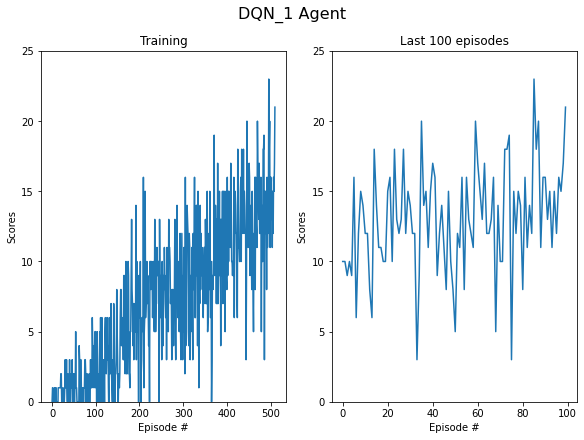

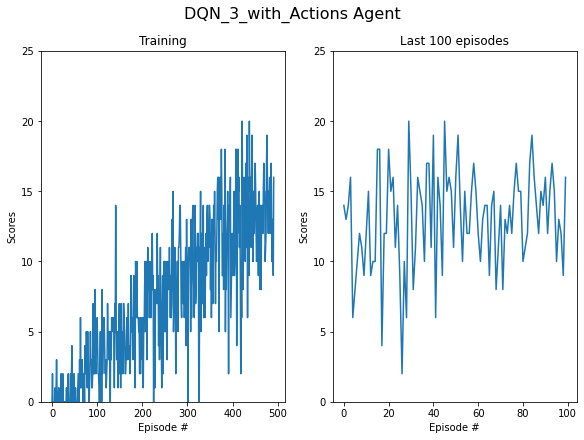

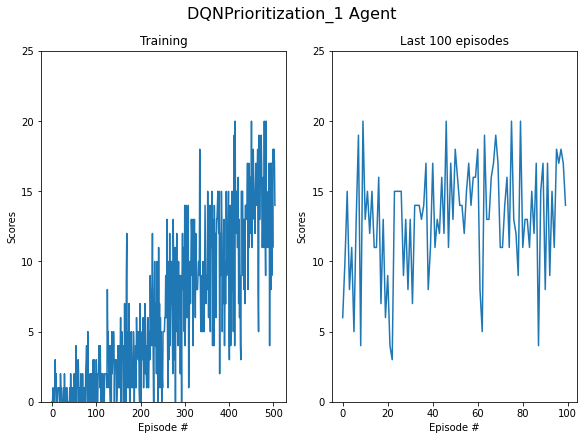

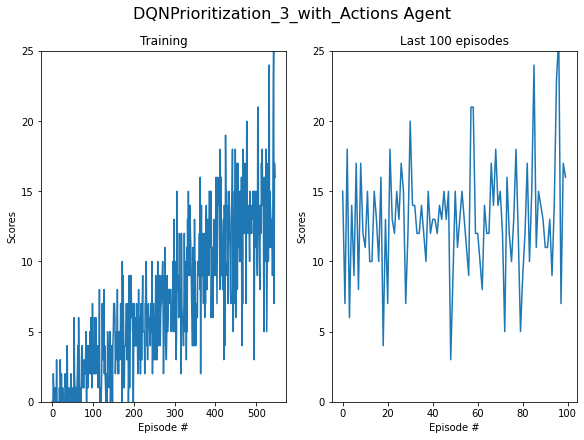

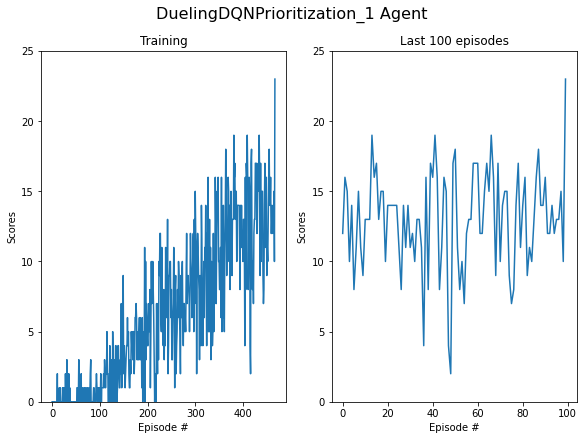

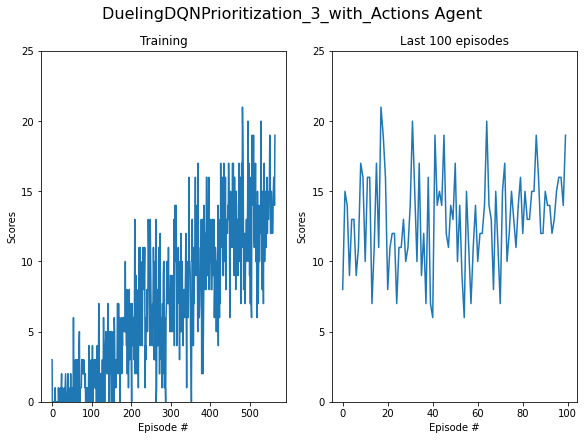

In [4]:
import agents

agent = agents.SimpleAgent(state_size=state_size, action_size=action_size, seed=0)
scores, scores_window = train("DQN_1", agent, env, n_episodes=1000, history_length=1, add_action=False)

agent = agents.SimpleAgent(state_size=(state_size+action_size)*3, action_size=action_size, seed=0)
scores, scores_window = train("DQN_3_with_Actions", agent, env, n_episodes=1000, history_length=3, add_action=True)

agent = agents.SimpleAgentwithPrioritization(state_size=state_size, action_size=action_size, seed=0)
scores, scores_window = train("DQNPrioritization_1", agent, env, n_episodes=1000, history_length=1, add_action=False)

agent = agents.SimpleAgentwithPrioritization(state_size=(state_size+action_size)*3, action_size=action_size, seed=0)
scores, scores_window = train("DQNPrioritization_3_with_Actions", agent, env, n_episodes=1000, history_length=3, add_action=True)

agent = agents.DuelingAgentwithPrioritization(state_size=state_size, action_size=action_size, seed=0)
scores, scores_window = train("DuelingDQNPrioritization_1", agent, env, n_episodes=1000, history_length=1, add_action=False)

agent = agents.DuelingAgentwithPrioritization(state_size=(state_size+action_size)*3, action_size=action_size, seed=0)
scores, scores_window = train("DuelingDQNPrioritization_3_with_Actions", agent, env, n_episodes=1000, history_length=3, add_action=True)


In [5]:
env.close()

### Test results

You can run the test using the notebook ```test.ipynb```. The results for execution of 20 times of testing is presented below.

#### 1. Double Q-learning with Experience Replay
<figure class="image" style="display:inline-block">
  <img src="./figs/testDQN_1.jpg" width="400" class="center"/>
</figure>

<figure class="image" style="display:inline-block">
  <img src="./figs/testDQN_3_with_Actions.jpg" width="400" class="center"/>
</figure>

#### 2. Double Q-learning with Prioritized Experience Replay
<figure class="image" style="display:inline-block">
  <img src="./figs/testDQNPrioritization_1.jpg" width="400" class="center"/>
</figure>

<figure class="image" style="display:inline-block">
  <img src="./figs/testDQNPrioritization_3_with_Actions.jpg" width="400" class="center"/>
</figure>


#### 3. Dueling Double Q-learning with Prioritized Experience Replay
<figure class="image" style="display:inline-block">
  <img src="./figs/testDuelingDQNPrioritization_1.jpg" width="400" class="center"/>
</figure>

<figure class="image" style="display:inline-block">
  <img src="./figs/testDuelingDQNPrioritization_3_with_Actions.jpg" width="400" class="center"/>
</figure>

### Observation and conclusion
Although the tests are not covering all aspects, a rough picture will be that use of history improves the learning and results of the game. The agent trained with 3 steps of states and its own actions behaves in a more stable manner. It is difficult to judge whether with the current choice of hyper parameters the prioritization of the expareiences, as well as use of dueling network give any positive contribution alone, when only one state is considered. However, when the history is considered, the results becomes better with dueling network and experience prioritization.

I have an impression that results of the tests were not we good as what could be expected from the last 100 episodes.

### Acknowldgement

I had great advantage from going through the implementation and the code presented [here](https://github.com/higgsfield/RL-Adventure).

